In [2]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [3]:
INPUT_FILENAME = 'connectivities_classifier-SVM_measure-accuracy_shap-disabled_agg-region_top-10_cv-100x4fold'

RESULTS = xr.open_dataset('models/' + INPUT_FILENAME + '.nc5').load()

RESULTS

<xarray.Dataset>
Dimensions:                           (subject: 32, grid_model_name: 15,
                                       y_classes: 2)
Coordinates:
  * grid_model_name                   (grid_model_name) object 'gordon2014_re...
  * y_classes                         (y_classes) object 'AVGP' 'NVGP'
Dimensions without coordinates: subject
Data variables: (12/116)
    X                                 (subject) object 'AVGP01' ... 'NVGP19NEW'
    y                                 (subject) object 'AVGP' 'AVGP' ... 'NVGP'
    param_connectivity__kind          (grid_model_name) object 'partial corre...
    param_connectivity__atlas         (grid_model_name) object 'gordon2014_2m...
    mean_fit_time                     (grid_model_name) float64 1.663 ... 0.5576
    std_fit_time                      (grid_model_name) float64 0.2663 ... 0....
    ...                                ...
    std_test_score                    (grid_model_name) float64 0.1523 ... 0....
    rank_test_score                   (grid_model_name) int32 14 7 5 ... 12 2 3
    scoring                           object 'accuracy'
    cv_test_size                      int32 8
    cv_n_splits                       int32 100
    n_subjects                        int32 32

In [4]:
# prep grid data

n_subjects = RESULTS['n_subjects'].item()
X = RESULTS['X'].values
y = RESULTS['y'].values
cv_n_splits = RESULTS['cv_n_splits'].item()
cv_test_size = RESULTS['cv_test_size'].item()
scoring = RESULTS['scoring'].item()


split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = RESULTS[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)


scores['atlas'] = scores['label'].apply(lambda x: '_'.join(x.split('_')[0:2]))
scores['kind'] = scores['label'].apply(lambda x: x.split('_')[2])

scores = scores[['label', 'atlas', 'kind', 'test_score', 'mean_test_score']]

# simulate chance
chance_scores = {}
for model_name in scores['label'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y,
                                     cv=StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size), scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='label')

# sort, mean score and ordering
scores = scores.sort_values('mean_test_score', ascending=True)
mean_scores = scores.groupby('label')[['test_score']].mean().reset_index()
order = scores['label'].drop_duplicates()

# percentage accuracy
scores['accuracy_pct'] = scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0


In [5]:
# Calculate and report 95% confidence intervals

from scipy.stats import bootstrap
import numpy as np

def calculate_ci(scores):
    bootstrap_ci = bootstrap((scores.values,), np.mean, confidence_level=0.95, method='percentile')

    return bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high


scores.groupby(['atlas','kind'])['accuracy_pct'].apply(calculate_ci)

atlas                  kind               
difumo64_regions       correlation                           (45.5, 51.0)
                       covariance                          (44.25, 50.75)
                       partial-correlation               (57.125, 63.875)
                       precision              (57.375, 63.13124999999991)
                       tangent                            (54.25, 61.375)
dosenbach2010_regions  correlation                         (46.625, 53.0)
                       covariance               (45.0, 52.13124999999991)
                       partial-correlation               (41.875, 48.125)
                       precision                          (43.375, 50.75)
                       tangent                           (44.375, 50.875)
gordon2014_regions     correlation                         (45.75, 51.75)
                       covariance                         (48.25, 54.375)
                       partial-correlation                (42.875, 48

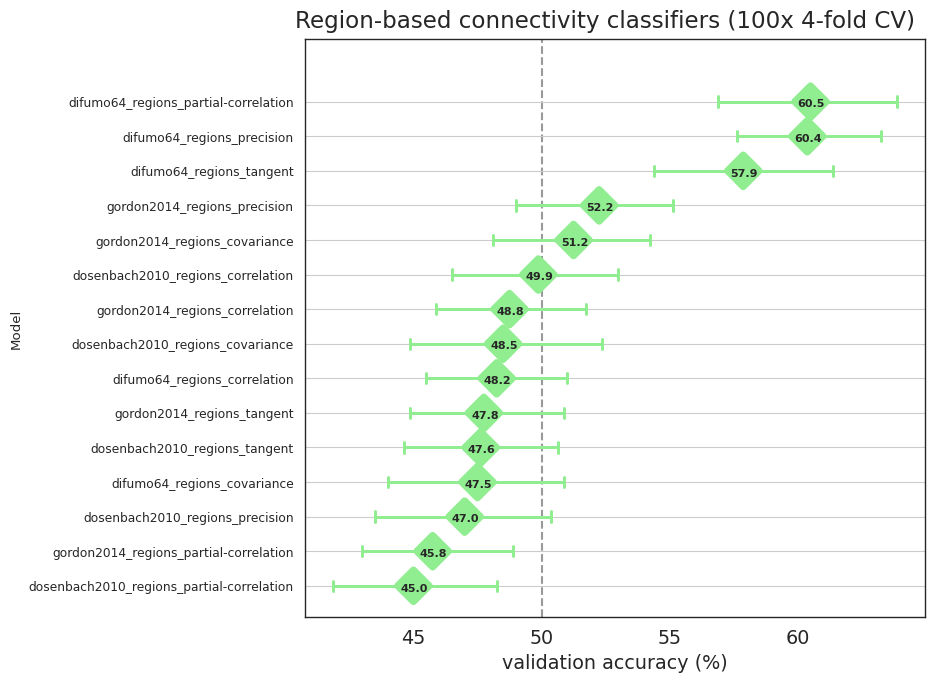

In [20]:
sns.set('paper', 'white')
_, ax = plt.subplots(figsize=(8, len(RESULTS['grid_model_name']) * .5))

def jitter(df, column='cv_test_score', jitter_size=.03):
    jittered_df = df.copy()
    jittered_df[column] = jittered_df[column] + np.random.uniform(-jitter_size, jitter_size, len(df))
    return jittered_df    

# plot chance
# g = sns.pointplot(data=chance_scores,
#               x='accuracy_pct', y='label',
#               order=order,
#               join=False,
#             #   markers='D',
#               color='gray',
#               capsize=0.3,
#               # cmap='viridis',
#               # size=5,
#               ax=ax,
#               label='chance')
# plt.setp(g.collections, alpha=.3) # alpha the markers
# plt.setp(g.lines, alpha=.3) # alpha the lines

# observation
g = sns.pointplot(data=scores,
              x='accuracy_pct', y='label', order=order,
              join=False,
              color='lightgreen',
              markers='D',
              capsize=0.3,
              scale=3,
              # cmap='viridis',
              # plot_kws=dict(zorder=1),
              ax=ax,
              label='observation')

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, model_name, cv_test_score, accuracy_pct in mean_scores.itertuples():
    ticklabel_idx = y_ticklabels.index(model_name)
    ax.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-.5, ticklabel_idx-0.15), weight='bold', size=8)

ax.grid(axis='y')

ax.axvline(x=50, linestyle='--', color='gray', linewidth=1.5, alpha=.8, label='theoretical chance', zorder=-1)

# motion confounds clasifier
# ax.scatter([51.4], [-.7], marker='^', s=160, color='gray')

ax.set(ylabel='Model', ylim=(-.9, len(order)+.8))
ax.set_xlabel('validation accuracy (%)', fontsize='x-large')

# plt.legend().set_visible(False)
# plt.legend()

plt.xticks(fontsize='x-large')

plt.suptitle(f'Region-based connectivity classifiers ({cv_n_splits}x 4-fold CV)', fontsize='xx-large', y=.92)
plt.savefig(f'outputs/figures/{INPUT_FILENAME}.png', bbox_inches='tight')